Analyzing Data using Python and SQLite3
===

## SQLite basics

 * Create a connection
   * `conn = sqlite3.connect('database_file')`
   * `cur = conn.curser()`
 * Execute SQL commands
   * execute: `cur.execute('SQL COMMANDS')`
   * commit to save changes made to the database: `conn.commit()`
 * Retrieve results
   * execute the retrieval query `cur.execute('SELECT QUERY')`
   * Fetch the results
     * Fetch all the results at once: `cur.fecthall()`
     * Fetch only one result: `cur.fetchone()`
 * Close the connection
   * `conn.close()`

## Data types

|Data Type|	Affinity|
|:--|:--:|
|INT INTEGER TINYINT SMALLINT <br> MEDIUMINT BIGINT UNSIGNED<br> BIG INT INT2 INT8|	INTEGER|
|CHARACTER(20) VARCHAR(255) <br>VARYING CHARACTER(255) <br>NCHAR(55) NATIVE CHARACTER(70) <br> NVARCHAR(100) TEXT CLOB|	TEXT|
|BLOB no datatype specified	|NONE|
|REAL DOUBLE <br>DOUBLE PRECISION FLOAT	|REAL|

#### Example: create a table to store data from a textfile

 
 * First, create a connection

In [1]:
import sqlite3

conn = sqlite3.connect('election_tweets.sqlite')
cur = conn.cursor()

 * Setup/create a table

In [2]:
cur.execute("DROP TABLE IF EXISTS Tweets")

cur.execute("CREATE TABLE Tweets(state VARCHAR(10), party VARCHAR(20), sentiment INT2)")

conn.commit()

 * Read data using pandas and store them in sqlite 

In [4]:
import pandas as pd

reader = pd.read_table('http://vahidmirjalili.com/election-2016/opFromNLP-2.txt', 
                       sep='|', header=None, chunksize=100)

sentiment={'Neutral':0,
           'Positive':1,
           'Negative':-1}

for chunk in reader:
    for i in range(chunk.shape[0]):
        line = chunk.iloc[[i]].values[0]
        cur.execute("INSERT INTO Tweets (state, party, sentiment) \
                    VALUES (?,?,?)",
                  (line[0], line[1], sentiment[line[2]]))
    conn.commit()

## Summarizing Queries

 * Total number of tweets
```sql
SELECT COUNT(*) 
FROM Tweets;
```
 * Total number of neutral/positive/negative tweets
```sql
SELECT sentiment,COUNT(*)
FROM Tweets
GROUP BY sentiment;
```
 * Sum of sentiment values in each state for each party
```sql
SELECT state,pary,SUM(sentiment)
FROM Tweets
GROUP BY state,party;
```

In [2]:
cur.execute('SELECT count(*) FROM Tweets')
num_tweets = cur.fetchall()
print('Total number of tweets: %d'%(num_tweets[0]))

Total number of tweets: 1063888


In [3]:
cur.execute('SELECT sentiment,COUNT(*) FROM Tweets GROUP BY sentiment')
results = cur.fetchall()

for res in results:
    print("Count of %d tweets: %d"%(res[0], res[1]))

Count of -1 tweets: 563479
Count of 0 tweets: 347179
Count of 1 tweets: 153230


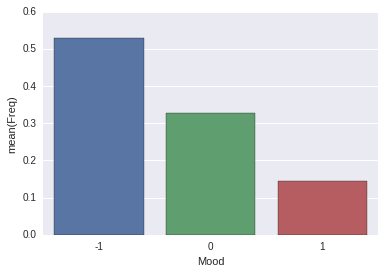

In [16]:
import seaborn as sns
import matplotlib
import numpy as np
import pandas as pd

results = pd.DataFrame(results)

results.columns = ['Mood', 'Freq']
results['Freq'] = results['Freq']/np.sum(results['Freq'])

%matplotlib inline

ax = sns.barplot(x="Mood", y="Freq", data=results)

In [17]:
cur.execute('SELECT state,SUM(sentiment),count(*) \
            FROM Tweets WHERE party="Democrat" GROUP BY state')
dem_results = cur.fetchall()
cur.execute('SELECT state,SUM(sentiment),count(*) \
            FROM Tweets WHERE party="Republican" GROUP BY state')
rep_results = cur.fetchall()

for dem_res,rep_res in zip(dem_results,rep_results):
    if(len(dem_res[0]) == 2):
        print("%s\tDemocrat: %6.2f\tRepublican: %6.2f"%(
                dem_res[0], dem_res[1]/dem_res[2], rep_res[1]/rep_res[2]))

AK	Democrat:  -0.33	Republican:  -0.31
AL	Democrat:  -0.30	Republican:  -0.30
AR	Democrat:  -0.45	Republican:  -0.43
AZ	Democrat:  -0.36	Republican:  -0.37
CA	Democrat:  -0.39	Republican:  -0.39
CO	Democrat:  -0.36	Republican:  -0.32
CT	Democrat:  -0.47	Republican:  -0.47
DC	Democrat:   0.00	Republican:  -0.33
DE	Democrat:  -0.27	Republican:  -0.40
FL	Democrat:  -0.18	Republican:  -0.17
GA	Democrat:  -0.30	Republican:  -0.32
HI	Democrat:  -0.37	Republican:  -0.39
IA	Democrat:  -0.15	Republican:  -0.16
ID	Democrat:  -0.36	Republican:  -0.35
IL	Democrat:  -0.39	Republican:  -0.40
IN	Democrat:  -0.29	Republican:  -0.29
KS	Democrat:  -0.27	Republican:  -0.27
KY	Democrat:  -0.86	Republican:  -0.87
LA	Democrat:  -0.25	Republican:  -0.25
MA	Democrat:  -0.32	Republican:  -0.34
MD	Democrat:  -0.21	Republican:  -0.20
ME	Democrat:  -0.64	Republican:  -0.65
MI	Democrat:  -0.50	Republican:  -0.50
MN	Democrat:  -0.36	Republican:  -0.35
MO	Democrat:  -0.29	Republican:  -0.32
MS	Democrat:  -0.81	Repub

In [30]:
dem_df = pd.DataFrame(dem_results)
rep_df = pd.DataFrame(rep_results)

df = pd.DataFrame({'state':dem_df[0], 'dem':dem_df[2], 'rep':rep_df[2], 'tot':dem_df[2]+rep_df[2]})

df.to_csv('/tmp/res', sep=' ')

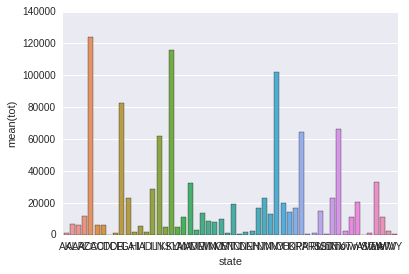

In [28]:
ax = sns.barplot(x="state", y="tot", data=df)

In [20]:
for dem_res,rep_res in zip(dem_results,rep_results):
    if(len(dem_res[0]) == 2):
        if (dem_res[1]/dem_res[2] > rep_res[1]/rep_res[2]):
            print("%s\tDemocrat  \t%.3f"%(
                    dem_res[0], dem_res[1]/dem_res[2] -rep_res[1]/rep_res[2]))
        else:
            print("%s\tRepublican\t%.3f"%(
                    rep_res[0], rep_res[1]/rep_res[2] - dem_res[1]/dem_res[2]))

AK	Republican	0.024
AL	Democrat  	0.005
AR	Republican	0.020
AZ	Democrat  	0.004
CA	Republican	0.007
CO	Republican	0.039
CT	Republican	0.005
DC	Democrat  	0.333
DE	Democrat  	0.123
FL	Republican	0.003
GA	Democrat  	0.016
HI	Democrat  	0.011
IA	Democrat  	0.013
ID	Republican	0.010
IL	Democrat  	0.009
IN	Republican	0.003
KS	Republican	0.002
KY	Democrat  	0.006
LA	Republican	0.003
MA	Democrat  	0.012
MD	Republican	0.011
ME	Democrat  	0.015
MI	Democrat  	0.001
MN	Republican	0.005
MO	Democrat  	0.025
MS	Democrat  	0.005
MT	Republican	0.050
NC	Democrat  	0.008
ND	Republican	0.015
NE	Democrat  	0.024
NH	Republican	0.018
NJ	Republican	0.003
NM	Republican	0.001
NV	Democrat  	0.000
NY	Republican	0.006
OH	Democrat  	0.027
OK	Democrat  	0.000
OR	Republican	0.011
PA	Democrat  	0.008
PR	Republican	0.052
RI	Democrat  	0.010
SC	Democrat  	0.015
SD	Republican	0.064
TN	Democrat  	0.017
TX	Democrat  	0.012
UT	Democrat  	0.044
VA	Republican	0.010
VI	Republican	0.350
VT	Democrat  	0.128
WA	Republican	0.002


In [31]:
for dem_res,rep_res in zip(dem_results,rep_results):
    if(len(dem_res[0]) == 2):
            print("%s\tDemocrat  \t%.3f"%(
                    dem_res[0], dem_res[1]/dem_res[2] -rep_res[1]/rep_res[2]))

AK	Democrat  	-0.024
AL	Democrat  	0.005
AR	Democrat  	-0.020
AZ	Democrat  	0.004
CA	Democrat  	-0.007
CO	Democrat  	-0.039
CT	Democrat  	-0.005
DC	Democrat  	0.333
DE	Democrat  	0.123
FL	Democrat  	-0.003
GA	Democrat  	0.016
HI	Democrat  	0.011
IA	Democrat  	0.013
ID	Democrat  	-0.010
IL	Democrat  	0.009
IN	Democrat  	-0.003
KS	Democrat  	-0.002
KY	Democrat  	0.006
LA	Democrat  	-0.003
MA	Democrat  	0.012
MD	Democrat  	-0.011
ME	Democrat  	0.015
MI	Democrat  	0.001
MN	Democrat  	-0.005
MO	Democrat  	0.025
MS	Democrat  	0.005
MT	Democrat  	-0.050
NC	Democrat  	0.008
ND	Democrat  	-0.015
NE	Democrat  	0.024
NH	Democrat  	-0.018
NJ	Democrat  	-0.003
NM	Democrat  	-0.001
NV	Democrat  	0.000
NY	Democrat  	-0.006
OH	Democrat  	0.027
OK	Democrat  	0.000
OR	Democrat  	-0.011
PA	Democrat  	0.008
PR	Democrat  	-0.052
RI	Democrat  	0.010
SC	Democrat  	0.015
SD	Democrat  	-0.064
TN	Democrat  	0.017
TX	Democrat  	0.012
UT	Democrat  	0.044
VA	Democrat  	-0.010
VI	Democrat  	-0.350
VT	Democrat  	0.1